In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from pprint import pprint
import matplotlib.dates as mdates
import scipy.stats as stats

from datetime import datetime

# I have a config file on my computer, you are going to have to add your own with the api key
from config import omdb_key



netflix_data = "resources/netflix_daily_top_10.csv"
netflix_titles_source = "resources/netflix_titles.csv"
netflix = pd.read_csv(netflix_data)
netflix_titles = pd.read_csv(netflix_titles_source)

In [165]:
len(netflix["As of"].unique())

710

# Cleaning up Outliers and Exploring Some Scatterplots

This section is just to remove outliers, namely "Cocomelon" and looking at a couple of scatterplots trying to gleam any information I could out of it

In [4]:

titles_unclean = netflix["Title"].unique()
titles = []
average_ranking = []
viewer_score = []

# remove cocomelon since it is such an extreme outlier
for title in titles_unclean:
    if title != "Cocomelon":
        titles.append(title)

for title in titles:
    average_ranking.append(netflix["Rank"].loc[netflix["Title"] == title].mean())
    viewer_score.append(netflix["Viewership Score"].loc[netflix["Title"] == title].mean())

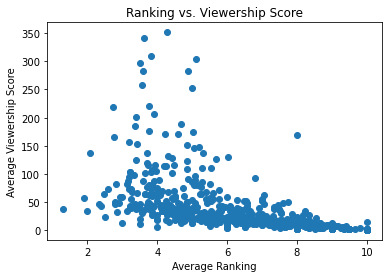

In [5]:
plt.scatter(average_ranking, viewer_score)
plt.xlabel("Average Ranking")
plt.ylabel("Average Viewership Score")
plt.title("Ranking vs. Viewership Score")
plt.show()

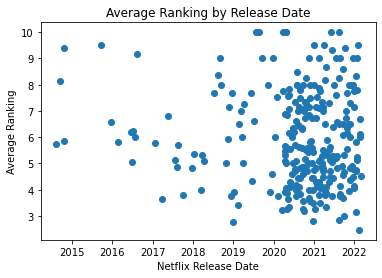

In [84]:
# Get a list of all of the dates in the dataset

date_raw = netflix["Netflix Release Date"].unique()
dates = []

# Convert the dates to datetime objects so that we can sort them in order
for date in date_raw:
    dates.append(datetime.strptime(date, '%b %d, %Y'))

dates.sort()

#remove the first one, since it is an outlier
dates.pop(0)
    
# Set up an empty list that we can add to as we go through the loop
average_ranking = []

# Note that the list dates contains a list of datetime objects, we use .strftime to convert it back
# to the format that the dataset uses
for date in dates:
    average_ranking.append(netflix["Rank"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].mean())
    
plt.scatter(dates, average_ranking)
plt.xlabel("Netflix Release Date")
plt.ylabel("Average Ranking")
plt.title("Average Ranking by Release Date")
plt.show()



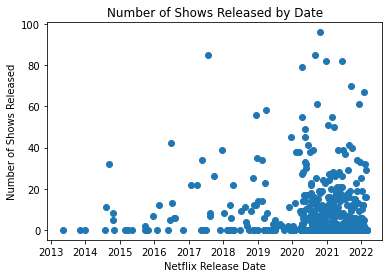

In [7]:
# This counts how many titles were released on each day

# I just realized that this counts how many times entries with that release date appear
# So titles that appear multiple times in the dataset count multiple times, so this data is a bit useless

released = []

for date in dates:
    released.append(netflix["Title"].loc[netflix["Netflix Release Date"] == date.strftime('%b %d, %Y')].count())
    
plt.scatter(dates, released)
plt.xlabel("Netflix Release Date")
plt.ylabel("Number of Shows Released")
plt.title("Number of Shows Released by Date")
plt.show()

# Using the OMDB API to Get More Information

Here I am using the OMDB API to get more information like show rating and online review scores

In [10]:
# Here we use the omdb API to get some extra info on all of our titles, just saving the json file to a dictionary for now

titles = netflix["Title"].unique()
json_data = {}
url = "http://www.omdbapi.com/?t="
api_key = "&apikey=" + omdb_key

for title in titles:
    response = requests.get(url + title + api_key)
    data = response.json()
    json_data[title] = data



In [81]:
# 72 titles were not reconized by the API, here is a list of all of them 
# Its short enough that we could enter it in manually if we really wanted to
titles_not_found = []

for title in titles:
    if json_data[title]['Response'] == 'False':
        titles_not_found.append(title)
        
titles_not_found

NameError: name 'json_data' is not defined

In [ ]:
# The goal here is to turn the json data we got from the api into a dataframe and save it as a csv file, then merge it
# So I first find the all the different pieces of data that json_data contains
columns = []

for title in titles:
    for entry in json_data[title]:
        if entry not in columns:
            columns.append(entry)
columns

In [ ]:
# Now that I know all the different pieces of data I can make a dictionary that I'll turn into a dataframe

omdb_data_dict = {
 'Title': [],
 'Response': [],
 'Error': [],
 'OMDB_Title': [],
 'Year' : [],
 'Rated' : [],
 'Released' : [],
 'Runtime' : [],
 'Genre' : [],
 'Director' : [],
 'Writer' : [],
 'Actors' : [],
 'Plot' : [],
 'Language' : [],
 'Country' : [],
 'Awards' : [],
 'Poster' : [],
 'Ratings' : [],
 'Metascore' : [],
 'imdbRating' : [],
 'imdbVotes' : [],
 'imdbID' : [],
 'Type' : [],
 'totalSeasons' : [],
 'DVD' : [],
 'BoxOffice': [],
 'Production': [],
 'Website': []
}

# loop through all the titles that we have
for title in titles:
    # Then loop through all the keys in the dictionary that we're trying to create
    for key in omdb_data_dict:
        
        # If the title in json_data doesn't have the appropriate column then I want to add N/A as a string so the lists 
        # in the dictionary are all the same length so it can all be put into a dataframe
        # I use N/A since thats what the api uses for missing data so its consistent
        try:
            omdb_data_dict[key].append(json_data[title][key])
        except:
            
            # I don't want to fill the title column with N/A since I want to merg on that later 
            if key == "Title":
                omdb_data_dict[key].append(title)                
            else:
                omdb_data_dict[key].append("N/A")
                
        
            
# With the dictionary complete let's turn it into a dataframe

omdb_df = pd.DataFrame(omdb_data_dict)
omdb_df.to_csv("resources/netflix-daily-top-10-omdb-data.csv")
omdb_df

# Here I'm Trying to Make Line Graphs

This section I'm trying to figure out a way to make line graphs to show trends in the data

In [176]:
# This code works, but it takes a really long time to complete (like 10+ minutes), 
# I need to streamline it a bit to make it faster or put it in a dataframe and save it as a csv

# Here I'm trying to get a list of all the unique dates and turn them into datetime objects so I can sort them
# The intent here is to build a dataframe with all the dates in a single column and then rankings on that date for an individual show in another 
# You can probably give it a column for every show to make graphing a shows change in position over time easier
as_of_dates = netflix["As of"].unique()
as_of_datetime = []

for date in as_of_dates:
    as_of_datetime.append(datetime.strptime(date, '%Y-%m-%d'))
as_of_datetime.sort()
as_of_datetime

# Make a dictionary with the 'as of' dates and every title that appears in the dataset as a key,
# and its value being a list of that title's rank on that day

# We start first with a dictionary of empty lists
ranking_trend = {"As of": []}

# We give it an empty list for each title
for title in netflix["Title"].unique():
    ranking_trend[title] = []
ranking_trend

# We loop through every date
for date in as_of_datetime:
    
    # Add that date to our ranking_trend dictionary
    ranking_trend["As of"].append(date)
    
    # Define this as the daily top 10 on that date
    daily_top_10 = netflix.loc[netflix["As of"] == date.strftime('%Y-%m-%d')]
    
    # Loop through each title that we have
    for title in netflix["Title"].unique():
        
        is_in_top_10 = False
        # Check if that title is in today's daily top 10 by going through each line
        # Then, if found, append its rank
        for i in range(10):
            
            top_10_line = daily_top_10.iloc[i]
            if top_10_line["Title"] == title:
                ranking_trend[title].append(top_10_line["Rank"])
                
                # If we found it in the top ten then set this variable to true
                is_in_top_10 = True
        
        # If it wasn't in the top 10 then we simply add "None" to the list
        if is_in_top_10 == False:
            ranking_trend[title].append(None)
    print(f"{date} is done")

In [188]:
# I found out that for some reason The Twilight Saga: Breaking Dawn had 5 extra values, so I deleted the last 5 entries
# on the list so that I turn ranking_trend to a dataframe and save it to a csv.
# Keep this in mind, if this ever comes up

These next two code blocks are for turning ranking_trend into a dataframe, then saving to a csv or reading from one

In [179]:
ranking_df = pd.DataFrame(ranking_trend)
ranking_df.set_index("As of")
ranking_df.to_csv("resources/netflix-daily-top-10-ranking-trends.csv", index=False)

In [177]:
ranking_df = pd.read_csv("resources/netflix-daily-top-10-ranking-trends.csv")
ranking_df

,As of,"Tiger King: Murder, Mayhem …",Ozark,All American,Blood Father,The Platform,Car Masters: Rust to Riches,Unorthodox,Love is Blind,Badland,...,Restless,Worst Roommate Ever,Shrek 2,Battleship,Just Like Heaven,Against the Ice,The Weekend Away,Pieces of Her,Shrek,Shooter
0,2020-04-01,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-02,1.0,2.0,3.0,6.0,9.0,10.0,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-03,1.0,2.0,3.0,10.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-04,1.0,2.0,4.0,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-05,1.0,2.0,5.0,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2022-03-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,2.0,8.0,NaN,10.0,NaN,6.0,1.0,9.0,NaN
706,2022-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,3.0,8.0,NaN,NaN,NaN,7.0,1.0,9.0,NaN
707,2022-03-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,4.0,7.0,NaN,NaN,NaN,9.0,1.0,8.0,10.0
708,2022-03-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,...,NaN,5.0,9.0,NaN,NaN,NaN,NaN,1.0,10.0,8.0


In [11]:
# Get the list of unique titles
titles_top_10 = netflix["Title"].unique()

# Get a list of all dates
time_period = ranking_df["As of"]

# We are going to get a list of days those titles were in the top 10, we start with an empty list
max_days_in_top_10 = {
    "Title": [],
    "Max Days in Top 10": [],
    "Type": [],
    "Netflix Exclusive": []
}

# Loop through the titles and get the max number of days it was in the top 10 (This would be the total number of days it shows up)
for title in titles_top_10:
    max_days_in_top_10["Title"].append(title)
    max_days_in_top_10["Max Days in Top 10"].append(netflix["Days In Top 10"].loc[netflix["Title"] == title].max())
    max_days_in_top_10["Type"].append(netflix["Type"].loc[netflix["Title"] == title].iloc[0])
    max_days_in_top_10["Netflix Exclusive"].append(netflix["Netflix Exclusive"].loc[netflix["Title"] == title].iloc[0])

max_days_in_top_10

# Turn that into a dataframe
max_days_in_top_10_df = pd.DataFrame(max_days_in_top_10)
max_days_in_top_10_df

,Title,Max Days in Top 10,Type,Netflix Exclusive
0,"Tiger King: Murder, Mayhem …",37,TV Show,Yes
1,Ozark,89,TV Show,Yes
2,All American,66,TV Show,NaN
3,Blood Father,7,Movie,NaN
4,The Platform,10,Movie,Yes
...,...,...,...,...
640,Against the Ice,2,Movie,Yes
641,The Weekend Away,6,Movie,Yes
642,Pieces of Her,7,TV Show,Yes
643,Shrek,7,Movie,NaN


In [113]:
# Look at the top 10 list on 4/21/2020
netflix.loc[netflix["As of"] == "2020-04-21"]

# Look at all the shows that were at number 1
netflix.loc[netflix["Rank"] == 1]

# Get the list of unique titles
titles_top_10 = netflix["Title"].unique()

# We are going to get a list of days those titles were in the top 10, we start with an empty list
max_days_in_top_10 = {
    "Title": [],
    "Max Days in Top 10": [],
    "Type": [],
    "Netflix Exclusive": []
}

# Loop through the titles and get the max number of days it was in the top 10 (This would be the total number of days it shows up)
for title in titles_top_10:
    max_days_in_top_10["Title"].append(title)
    max_days_in_top_10["Max Days in Top 10"].append(netflix["Days In Top 10"].loc[netflix["Title"] == title].max())
    max_days_in_top_10["Type"].append(netflix["Type"].loc[netflix["Title"] == title].iloc[0])
    max_days_in_top_10["Netflix Exclusive"].append(netflix["Netflix Exclusive"].loc[netflix["Title"] == title].iloc[0])

max_days_in_top_10

# Turn that into a dataframe
max_days_in_top_10_df = pd.DataFrame(max_days_in_top_10)
max_days_in_top_10_df

,Title,Max Days in Top 10,Type,Netflix Exclusive
0,"Tiger King: Murder, Mayhem …",37,TV Show,Yes
1,Ozark,89,TV Show,Yes
2,All American,66,TV Show,NaN
3,Blood Father,7,Movie,NaN
4,The Platform,10,Movie,Yes
...,...,...,...,...
640,Against the Ice,2,Movie,Yes
641,The Weekend Away,6,Movie,Yes
642,Pieces of Her,7,TV Show,Yes
643,Shrek,7,Movie,NaN


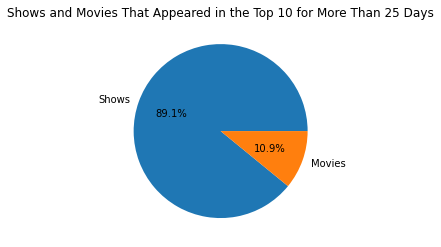

In [182]:
# We filter by things that were in the top 10 for more than 25 days

shows_in_top_10_for_more_than_25_days = max_days_in_top_10_df.loc[max_days_in_top_10_df["Max Days in Top 10"] >= 25]

show_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Type"] == "TV Show"])
movies_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Type"] == "Movie"])
netflix_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Netflix Exclusive"] == "Yes"])
non_netflix_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Netflix Exclusive"] != "Yes"])

fig1, ax1 = plt.subplots()
ax1.pie([show_pie, movies_pie], labels=["Shows", "Movies"], autopct='%1.1f%%')
plt.title("Shows and Movies That Appeared in the Top 10 for More Than 25 Days")
plt.show()


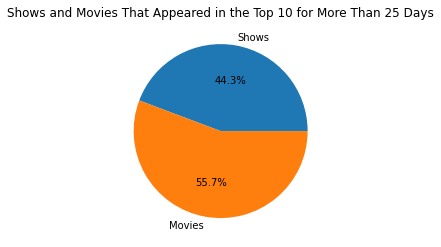

In [183]:
# I want to take a look at the overall distribution of movies and shows

shows_in_top_10_for_more_than_25_days = max_days_in_top_10_df

show_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Type"] == "TV Show"])
movies_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Type"] == "Movie"])
netflix_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Netflix Exclusive"] == "Yes"])
non_netflix_pie = len(shows_in_top_10_for_more_than_25_days.loc[shows_in_top_10_for_more_than_25_days["Netflix Exclusive"] != "Yes"])

fig1, ax1 = plt.subplots()
ax1.pie([show_pie, movies_pie], labels=["Shows", "Movies"], autopct='%1.1f%%')
plt.title("Shows and Movies That Appeared in the Top 10 for More Than 25 Days")
plt.show()


In [184]:
shows = netflix["Title"].loc[netflix["Type"] == 'TV Show'].unique()
movies = netflix["Title"].loc[netflix["Type"] == 'Movie'].unique()
stand_up = netflix["Title"].loc[netflix["Type"] == 'Stand-Up Comedy'].unique()
concert = netflix["Title"].loc[netflix["Type"] == 'Concert/Perf…'].unique()
shows_netflix_exclusive = netflix["Title"].loc[(netflix["Type"] == 'TV Show') & (netflix["Netflix Exclusive"] == "Yes")].unique()
shows_not_netflix_exclusive = netflix["Title"].loc[(netflix["Type"] == 'TV Show') & (netflix["Netflix Exclusive"] != "Yes")].unique()
movies_netflix_exclusive = netflix["Title"].loc[(netflix["Type"] == 'Movie') & (netflix["Netflix Exclusive"] == "Yes")].unique()
movies_not_netflix_exclusive = netflix["Title"].loc[(netflix["Type"] == 'Movie') & (netflix["Netflix Exclusive"] != "Yes")].unique()

print(f"""
Number of Shows  : {len(shows)}
Number of Movies : {len(movies)}
Number of Stand Up : {len(stand_up)}
Number of Concerts : {len(concert)}
""")



Number of Shows  : 283
Number of Movies : 355
Number of Stand Up : 6
Number of Concerts : 1



In [185]:
shows_rank = netflix["Rank"].loc[netflix["Type"] == 'TV Show'].mean()
movies_rank = netflix["Rank"].loc[netflix["Type"] == 'Movie'].mean()
stand_up_rank = netflix["Rank"].loc[netflix["Type"] == 'Stand-Up Comedy'].mean()
concert_rank = netflix["Rank"].loc[netflix["Type"] == 'Concert/Perf…'].mean()

print(f"""
Average Rank of Shows  : {shows_rank}
Average Rank of Movies : {movies_rank}
Average Rank of Stand Up : {stand_up_rank}
Average Rank of Concerts : {concert_rank}
""")


Average Rank of Shows  : 5.422177237966712
Average Rank of Movies : 5.635005744925316
Average Rank of Stand Up : 5.439024390243903
Average Rank of Concerts : 3.5



<AxesSubplot:title={'center':'Average Ranking of Shows and Movies for the First 60 Days'}>

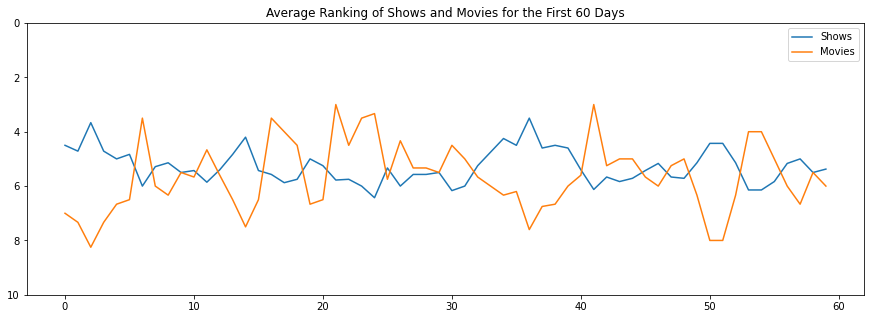

In [186]:

shows_mean_ranking = ranking_df[shows].mean(axis=1)
movies_mean_ranking = ranking_df[movies].mean(axis=1)
stand_up_mean_ranking = ranking_df[stand_up].mean(axis=1)
concert_mean_ranking = ranking_df[concert].mean(axis=1)

netflix_shows_mean_ranking = ranking_df[shows_netflix_exclusive].mean(axis=1)
non_netflix_shows_mean_ranking = ranking_df[shows_not_netflix_exclusive].mean(axis=1)
netflix_movies_mean_ranking = ranking_df[movies_netflix_exclusive].mean(axis=1)
non_netflix_movies_mean_ranking = ranking_df[movies_not_netflix_exclusive].mean(axis=1)

daily_top_10_mean_ranking_df = pd.DataFrame(data={
    "As of":time_period,
    "Shows":shows_mean_ranking,
    "Movies":movies_mean_ranking,
    "stand up":stand_up_mean_ranking,
    "concert":concert_mean_ranking,
    "Netflix Shows":netflix_shows_mean_ranking,
    "Non Netflix Exclusive Shows":non_netflix_shows_mean_ranking,
    "Netflix Movies":netflix_movies_mean_ranking,
    "Non Netflix Movies":non_netflix_movies_mean_ranking
})


daily_top_10_mean_ranking_df[["Shows","Movies"]][:60].plot(ylim=(10, 0),title="Average Ranking of Shows and Movies for the First 60 Days",figsize=(15,5))

In [16]:
daily_top_10_mean_ranking_df["As of"].iloc[500]

'2021-08-14'

<AxesSubplot:title={'center':'Average Ranking of Netflix Exclusives vs Non-Exclusive Shows in the Last 60 Days'}>

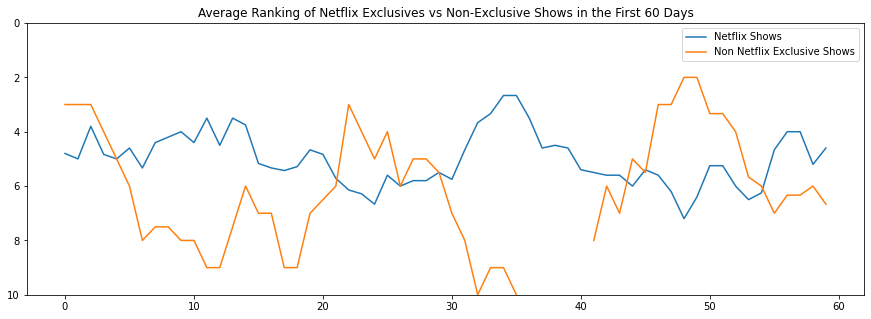

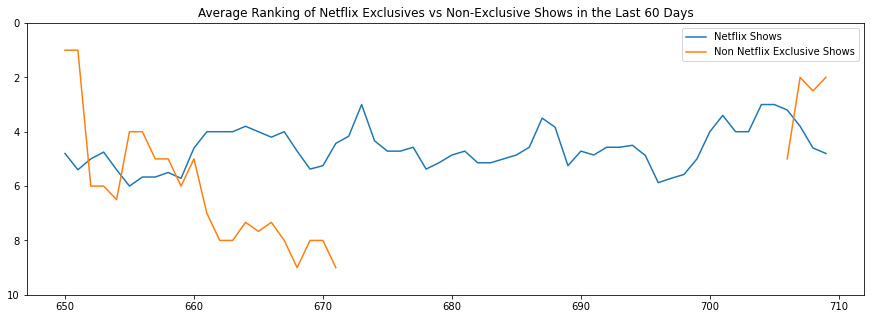

In [18]:
daily_top_10_mean_ranking_df[["Netflix Shows","Non Netflix Exclusive Shows"]][:60].plot(ylim=(10, 0),title="Average Ranking of Netflix Exclusives vs Non-Exclusive Shows in the First 60 Days",figsize=(15,5))
daily_top_10_mean_ranking_df[["Netflix Shows","Non Netflix Exclusive Shows"]][-60:].plot(ylim=(10, 0),title="Average Ranking of Netflix Exclusives vs Non-Exclusive Shows in the Last 60 Days",figsize=(15,5))

<AxesSubplot:title={'center':'Average Ranking of Netflix Exclusives vs Non-Exclusive Movies in the Last 60 Days'}>

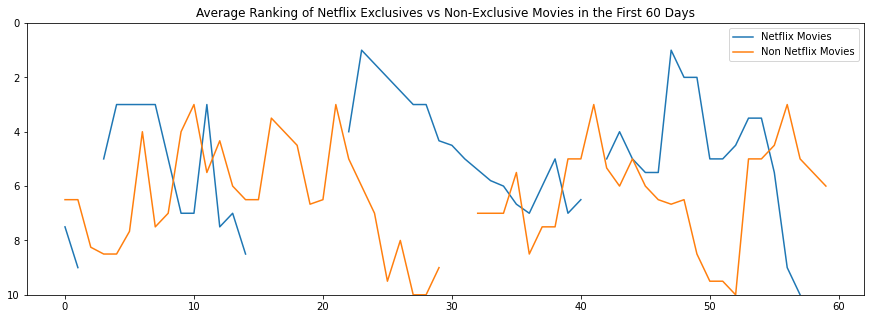

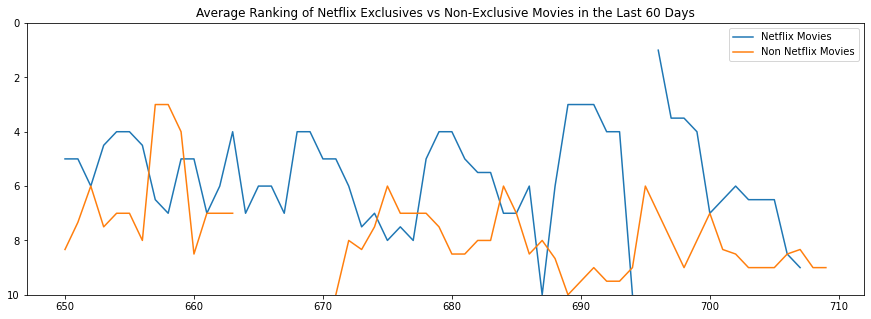

In [19]:
daily_top_10_mean_ranking_df[["Netflix Movies","Non Netflix Movies"]][:60].plot(ylim=(10, 0),title="Average Ranking of Netflix Exclusives vs Non-Exclusive Movies in the First 60 Days",figsize=(15,5))
daily_top_10_mean_ranking_df[["Netflix Movies","Non Netflix Movies"]][-60:].plot(ylim=(10, 0),title="Average Ranking of Netflix Exclusives vs Non-Exclusive Movies in the Last 60 Days",figsize=(15,5))

<AxesSubplot:title={'center':'Average Ranking of Shows and Movies Between 2020-04-01 and 2020-10-08'}>

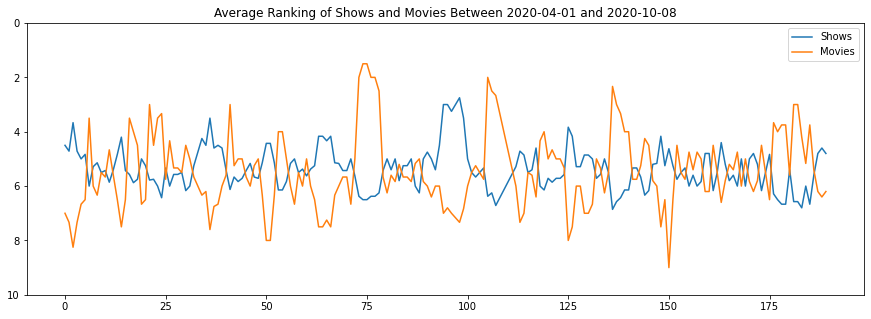

In [89]:
start_date = 0
end_date = 190


start = daily_top_10_mean_ranking_df["As of"].iloc[start_date]
end = daily_top_10_mean_ranking_df["As of"].iloc[end_date]
daily_top_10_mean_ranking_df[["Shows","Movies"]][start_date:end_date].plot(ylim=(10, 0),title=f"Average Ranking of Shows and Movies Between {start} and {end}",figsize=(15,5))

In [100]:
#ranking_df[["As of","Cocomelon"]].plot(ylim=(10,0), figsize=(20,5), title="Ranking of Cocomelon")
ranking_df["Cocomelon"].count()

428

<AxesSubplot:title={'center':'Mean Ranking of Content'}, ylabel='Position in the Daily Top 10'>

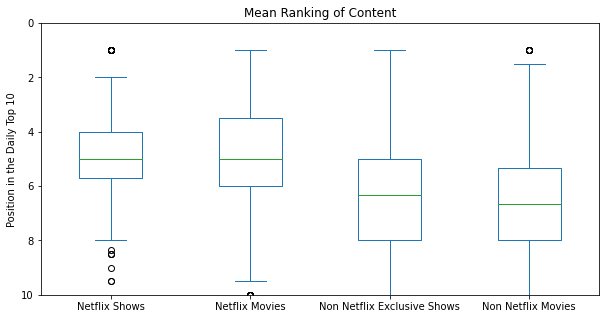

In [36]:
daily_top_10_mean_ranking_df[["Netflix Shows","Netflix Movies", "Non Netflix Exclusive Shows", "Non Netflix Movies"]].plot(kind="box", figsize=(10,5), ylim=(10,0), title="Mean Ranking of Content", ylabel="Position in the Daily Top 10")

In [160]:
max_days_in_top_10_df = max_days_in_top_10_df.loc[max_days_in_top_10_df["Title"] != "Cocomelon"]

C:\Users\wallh\AppData\Local\Temp/ipykernel_3292/3736856023.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  max_days_in_top_10_df.max()


Title                  Ãlite
Max Days in Top 10         89
Type                  TV Show
dtype: object

In [104]:
max_days_in_top_10_df.fillna("No", inplace=True)
max_days_in_top_10_df = max_days_in_top_10_df.loc[max_days_in_top_10_df["Max Days in Top 10"] != "No"]
max_days_grouped = max_days_in_top_10_df.groupby(["Netflix Exclusive", "Type"])
max_days_grouped.mean()
max_days_grouped.median()


C:\Users\wallh\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Max Days in Top 10
Netflix Exclusive Type                               
No                Movie                           6.0
                  TV Show                         9.5
Yes               Concert/Perf…                   2.0
                  Movie                           7.0
                  Stand-Up Comedy                 5.0
                  TV Show                         9.0

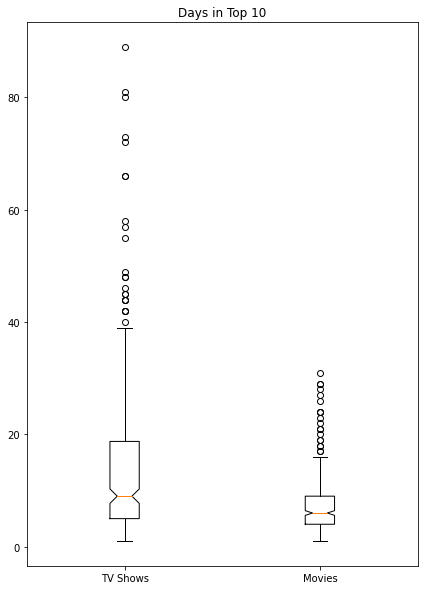

<Figure size 1440x720 with 0 Axes>

In [105]:


box_shows = max_days_in_top_10_df["Max Days in Top 10"].loc[max_days_in_top_10_df["Type"] == "TV Show"]
box_movies = max_days_in_top_10_df["Max Days in Top 10"].loc[max_days_in_top_10_df["Type"] == "Movie"]
box_titles = ["TV Shows", "Movies"]

fig1, ax1 = plt.subplots(figsize=(7,10))
ax1.set_title("Days in Top 10")
ax1.boxplot([box_shows, box_movies], box_titles)
plt.xticks([1,2], box_titles)
plt.figure(figsize=(20,10))
plt.show()

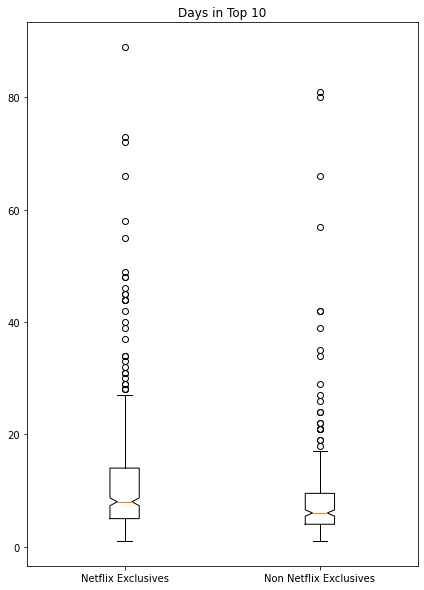

In [106]:
box_netflix = max_days_in_top_10_df["Max Days in Top 10"].loc[max_days_in_top_10_df["Netflix Exclusive"] == "Yes"]
box_non_netflix = max_days_in_top_10_df["Max Days in Top 10"].loc[max_days_in_top_10_df["Netflix Exclusive"] != "Yes"]
box_titles = ["Netflix Exclusives", "Non Netflix Exclusives"]

fig1, ax1 = plt.subplots(figsize=(7,10))
ax1.set_title("Days in Top 10")
ax1.boxplot([box_netflix, box_non_netflix], box_titles)
plt.xticks([1,2], box_titles)
plt.show()

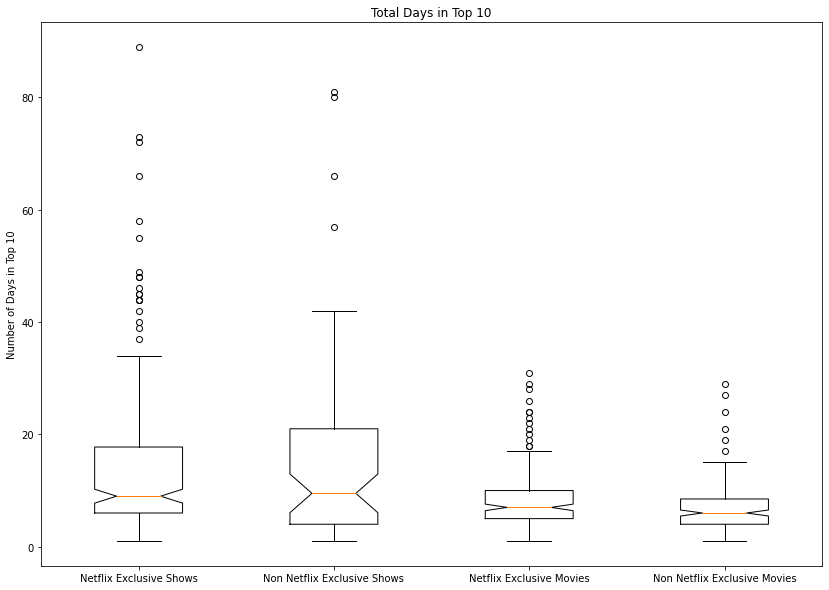

In [162]:
box_netflix_show = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] == "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "TV Show")]
box_netflix_movie = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] == "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "Movie")]
box_non_netflix_show = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] != "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "TV Show")]
box_non_netflix_movie = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] != "Yes") & 
                                                            (max_days_in_top_10_df["Type"] == "Movie")]
box_titles = ["Netflix Exclusive Shows",  "Non Netflix Exclusive Shows", "Netflix Exclusive Movies", "Non Netflix Exclusive Movies"]

fig1, ax1 = plt.subplots(figsize=(14,10))
ax1.set_title("Total Days in Top 10")
ax1.set_ylabel("Number of Days in Top 10")
ax1.boxplot([box_netflix_show, box_non_netflix_show, box_netflix_movie, box_non_netflix_movie], box_titles)
plt.xticks([1,2,3,4], box_titles)

plt.show()

In [170]:
start_date = 0
end_date = 7099

# Look at the top 10 list on 4/21/2020
netflix.loc[netflix["As of"] == "2020-04-21"]

# Look at all the shows that were at number 1
netflix.loc[netflix["Rank"] == 1]

# Get the list of unique titles
titles_top_10 = netflix["Title"].unique()

# We are going to get a list of days those titles were in the top 10, we start with an empty list
max_days_in_top_10 = {
    "Title": [],
    "Max Days in Top 10": [],
    "Type": [],
    "Netflix Exclusive": []
}

# Loop through the titles and get the max number of days it was in the top 10 (This would be the total number of days it shows up)
for title in titles_top_10:
    max_days_in_top_10["Title"].append(title)
    max_days_in_top_10["Max Days in Top 10"].append(netflix["Days In Top 10"].iloc[start_date:end_date].loc[netflix["Title"] == title].max())
    max_days_in_top_10["Type"].append(netflix["Type"].loc[netflix["Title"] == title].iloc[0])
    max_days_in_top_10["Netflix Exclusive"].append(netflix["Netflix Exclusive"].loc[netflix["Title"] == title].iloc[0])



# Turn that into a dataframe
max_days_in_top_10_df = pd.DataFrame(max_days_in_top_10)
max_days_in_top_10_df

max_days_in_top_10_df = max_days_in_top_10_df.loc[max_days_in_top_10_df["Title"] != "Cocomelon"]
max_days_in_top_10_df = max_days_in_top_10_df.loc[(max_days_in_top_10_df["Type"] == "TV Show") | (max_days_in_top_10_df["Type"] == "Movie")]

max_days_in_top_10_df.fillna("No", inplace=True)
max_days_in_top_10_df = max_days_in_top_10_df.loc[max_days_in_top_10_df["Max Days in Top 10"] != "No"]
max_days_grouped = max_days_in_top_10_df.groupby(["Netflix Exclusive", "Type"])
max_days_grouped.median()


Max Days in Top 10
Netflix Exclusive Type                       
No                Movie                   6.0
                  TV Show                 9.5
Yes               Movie                   7.0
                  TV Show                 9.0

In [97]:
netflix["As of"].iloc[end_date]

'2022-03-11'

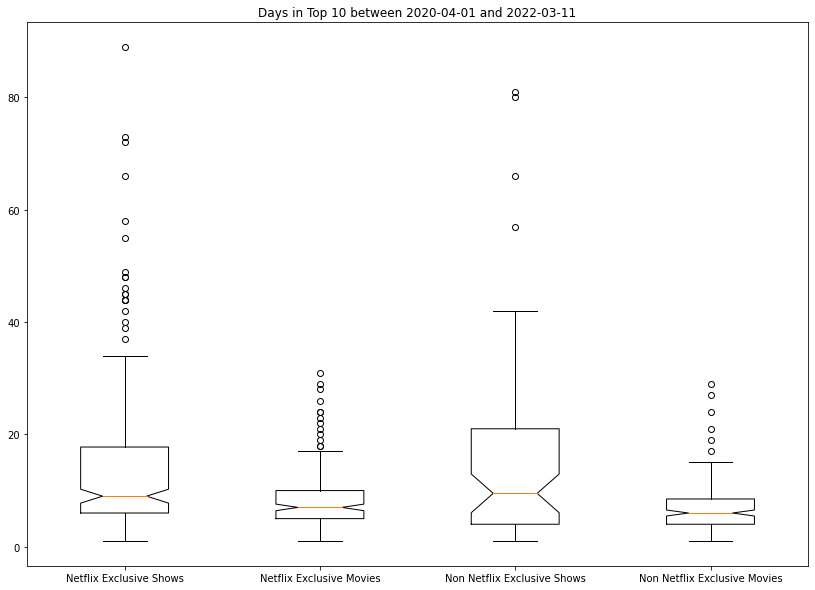

In [98]:
box_netflix_show = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] == "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "TV Show")]
box_netflix_movie = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] == "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "Movie")]
box_non_netflix_show = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] != "Yes") & 
                                                           (max_days_in_top_10_df["Type"] == "TV Show")]
box_non_netflix_movie = max_days_in_top_10_df["Max Days in Top 10"].loc[(max_days_in_top_10_df["Netflix Exclusive"] != "Yes") & 
                                                            (max_days_in_top_10_df["Type"] == "Movie")]
box_titles = ["Netflix Exclusive Shows", "Netflix Exclusive Movies", "Non Netflix Exclusive Shows", "Non Netflix Exclusive Movies"]

fig1, ax1 = plt.subplots(figsize=(14,10))
start = netflix["As of"].iloc[start_date]
end = netflix["As of"].iloc[end_date]
ax1.set_title(f"Days in Top 10 between {start} and {end}")
ax1.boxplot([box_netflix_show, box_netflix_movie, box_non_netflix_show, box_non_netflix_movie], box_titles)
plt.xticks([1,2,3,4], box_titles)
plt.show()